In [1]:
#imports
import time
import qcportal as ptl
import numpy as np
import matplotlib.pyplot as plt
from fragmenter.utils import HARTREE_2_KJMOL
from fragmenter import chemi
from simtk import unit
import os, sys
from fragmenter import chemi
import cmiles
from openeye import oechem
import qcportal as ptl
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from scipy import stats
import arch.bootstrap
import fragmenter 

# Analyze WBO Torsion

This script performs analysis on QCA datasets by finding the torsion barrier from their QCA record and calculating their ELF10 WBO with an AM1 calculation. 

## Data output
After data processing the molecules are stored into an oeb. Each respective OE molecule has the following data stored using datatags: 
 - tdr_object.id : int (id of the TD record) with datatag "TDid"
 - dihedral_indices: list (list of atom indices for which torsion is driven in this record) datatag "TDindices"
 - torsion_barrier: float (torsion barrier energy in KJ/mol, maximum of all the barriers) datatag "TB"
 - cmiles: str (string for the cmiles of the molecule in canonical_isomeric_explicit_hydrogen_mapped_smiles) datatag "cmiles"
 - wbo: float (float of the ELF10 wiberg bond order calculated between the central torsion idicies) datatag "wbo"
 - IDMatch: "IDMatch" that contain the torsion id from .offxml format FF involved in the QCA torsion drive datatag "IDMatch"

 
## Plotting 


In [77]:
#functions 
def torsion_barrier_for_molecule(tdr_object, mapped_smiles, show_plots=False):
    """
    Takes in a single torsion drive record that has energies from multiple conformers (at different torsion angles), evaluates the torsion barrier 
    
    Parameters
    ----------
    tdr_object : object
        torsion drive record from QC archive for a molecule
    
    Returns
    -------
    mol: oemol object
        oemol from the smiles in dataframe index that contains datatags with the following: 
        tdr_object.id : int (id of the TD record) with datatag "TDid"
        dihedral_indices: list (list of atom indices for which torsion is driven in this record) datatag "TDindices"
        torsion_barrier: float (torsion barrier energy in KJ/mol, maximum of all the barriers) datatag "TB"
        cmiles: str (string for the cmiles of the molecule in canonical_isomeric_explicit_hydrogen_mapped_smiles) datatag "cmiles"
    """
    energies = list(tdr_object.get_final_energies().values())
    tmp = list(tdr_object.get_final_energies().keys())
    angles = [i[0]*np.pi/180 for i in tmp]
    angles, energies = zip(*sorted(zip(angles, energies)))
    angles = np.array(angles)
    energies = np.array(energies)
    angles = np.append(angles[-3:] - 2*np.pi, np.append(angles, angles[:3] + 2*np.pi))
    energies = np.append(energies[-3:], np.append(energies, energies[:3]))
    
    idx = []
    for i in range(len(angles)-2):
        m1 = (energies[i+1]-energies[i])/(angles[i+1]-angles[i])
        m2 = (energies[i+2]-energies[i+1])/(angles[i+2]-angles[i+1])
        if np.sign(m1) == np.sign(m2):
            continue
        else:
            idx.append(i+1)
        
    if (show_plots):
        min_ener = min(energies)
        energies_y = (energies-min_ener)*HARTREE_2_KJMOL
        fontsize = 14
        plt.figure()
        plt.plot(angles*180/np.pi, energies_y, 'b-X', angles[idx]*180/np.pi, energies_y[idx], 'ro')
        plt.legend(['QM data', 'Max, min'], bbox_to_anchor=(1, 1), fontsize=fontsize)
        plt.title('Torsion drive interpolation', fontsize=fontsize)
        plt.xlabel('Dihedral Angle [Degrees]', fontsize=fontsize)
        plt.ylabel('Relative energy [KJ / mol]', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        fig_name = 'plot_' + tdr_object.id + '.png'
        plt.savefig(fig_name)
        plt.show()
        
    torsion_barriers = []
    for i in range(int(len(idx)-1)):
        torsion_barriers.append(abs(HARTREE_2_KJMOL*abs(energies[idx[i]] - energies[idx[i+1]])))
    torsion_barriers = np.array(torsion_barriers)
    
    # get dihedral indices and pass on to get_wbo function
    dihedral_indices = tdr_object.dict()['keywords']['dihedrals'][0]
    offmol = Molecule.from_mapped_smiles(mapped_smiles)
    offmol.assign_fractional_bond_orders()
    bond = offmol.get_bond_between(dihedral_indices[1], dihedral_indices[2])
    mol = chemi.smiles_to_oemol(mapped_smiles)
    mol.SetData("WBO", bond.fractional_bond_order)
    mol.SetData("TB", max(torsion_barriers))
    mol.SetData("TDindices", dihedral_indices)
    mol.SetData("TDid", tdr_object.id)
    mol.SetData("cmiles", mapped_smiles)
    
    return mol

    

def loadDataset_low(datasetName, specification):
    """
    Low level call to load each torsion drive dataset and return a list of molecules
    
        Parameters
        ----------
        datasetName : str
            torsion drive dataset name.  
        specification : str
            specification in the dataset. Example: "B3LYP-D3", "default", "UFF" 
        
        Returns
        -------
        molList : list of objects
            each row contains the tdr_object.id, dihedral_indices, torsion_barrier, oemol_object
    """
    while True:    
        try:
            assert(datasetName)
            break
        except AssertionError:
            print ("datasetName is empty. Check input list of dataset tuples")
            raise
    while True:    
        try:
            assert(specification)
            break
        except AssertionError:
            print ("specification is empty. Check input list of dataset tuples")
            raise

    # initiate qc portal instance
    client = ptl.FractalClient()    
    # from the TorsionDriveDataset collection picking up given datasetName
    ds = client.get_collection("TorsionDriveDataset", datasetName)
    ds.status([specification], status="COMPLETE")
 
    # Serial implementation
    tb = []
    for i in range(ds.df.size):
        if (ds.df.iloc[i,0].status == 'COMPLETE'):
            smiles = ds.df.index[i]
            mapped_smiles = ds.get_entry(smiles).attributes['canonical_isomeric_explicit_hydrogen_mapped_smiles']
            tb.append(torsion_barrier_for_molecule(ds.df.iloc[i, 0], mapped_smiles))
    print("No. of COMPLETE records in this dataset:", len(tb), "out of ", len(ds.df))
    
    return(tb)




def checkTorsion(molList):
    """
    Take mollist and check if the molecules in a list match a specific torsion id
    
        Parameters
        ----------
        molList : List of objects
            List of oemols with datatags generated in genData function

        Returns
        -------
        molList : list of objects
            List of oemol objects that have a datatag "IDMatch" that contain the torsion id involved in the QCA torsion drive 
    """

    matches=[]
    count=0
    mols=[]
    for mol in molList: 
        molecule = Molecule.from_mapped_smiles(mol.GetData("cmiles"))
        topology = Topology.from_molecules(molecule)
        # Let's label using the Parsley force field
        forcefield = ForceField('openff-1.2.1.offxml')
        # Run the molecule labeling
        molecule_force_list = forcefield.label_molecules(topology)
        params=[]
        # Print out a formatted description of the torsion parameters applied to this molecule
        for mol_idx, mol_forces in enumerate(molecule_force_list):
            #print(f'Forces for molecule {mol_idx}')
            for force_tag, force_dict in mol_forces.items():
                if force_tag == 'ProperTorsions':
                    for (atom_indices, parameter) in force_dict.items():
                        params.append(parameter.id)
                        if atom_indices == mol.GetData("TDindices") or tuple(reversed(atom_indices)) == mol.GetData("TDindices"):
                            count+=1
                            mol.SetData("IDMatch", parameter.id)
                            mols.append(mol)
    print("Out of " +str(len(molList)) + " molecules, " + str(count) + " were processed with checkTorsion()")

    return mols 


def makeOEB(oemolList, tag):
    """
    Take mollist and create oeb file using the tag as the .oeb file name  
    
        Parameters
        ----------
        molList : List of objects
            List of oemols with datatags generated in genData function
        tag : String
            Title of the oeb file 

        Returns
        -------
    """
    ofile = oechem.oemolostream(tag+'.oeb')
    for mol in oemolList:
        oechem.OEWriteConstMolecule(ofile, mol)
    ofile.close()
    return



def compute_r_ci(wbos, max_energies):
    return (stats.linregress(wbos, max_energies)[2])**2


def oeb2oemol(oebfile):
    """
    Takes in oebfile and generates oemolList
        Parameters
        ----------
        oebfile : String
            Title of an oeb file
        Returns
        -------
        mollist : List of objects
            List of OEMols in the .oeb file
            
    """
    ifs = oechem.oemolistream(oebfile)
    mollist = []

    for mol in ifs.GetOEGraphMols():
            mollist.append(oechem.OEGraphMol(mol))

    return mollist



#plotting functions
def genPlots(fileName, fname):
    """
    Generates a .pdf plot from a .oeb file of wbo versus torsion barrier height 
        Parameters
        ----------
        fileName : String
            .oeb file name for the molecules that contain datatags with plotting information
        fname : String
            The output .pdf file name for the resulting files from the plotting function 

        Returns
        -------
    """

    molList=oeb2oemol(fileName)
    
    torsionDict={}
    #print(molList)
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]={}
        torsionDict[tid]['tb']=[]
        torsionDict[tid]['wbo']=[]
    #print(torsionDict)
    
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]['tb'].append(m.GetData("TB"))
        torsionDict[tid]['wbo'].append(m.GetData("WBO"))
    
    colors = [
"#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
"#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
"#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
"#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
"#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C", "#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
"#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
"#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
"#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
"#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
"#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
"#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
"#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
"#34362D"]
    
    fig,ax=plt.subplots()

    for i, (key, item) in enumerate(torsionDict.items()):
        ax.scatter(torsionDict[key]['wbo'],torsionDict[key]['tb'],c=colors[i], label=key)
#         slope, intercept, r_value, p_value, std_err = stats.linregress(torsionDict[key]['wbo'], torsionDict[key]['tb'])
#         print(key)
#         print(r_value)
#         print(slope)
#         print(intercept)
#         ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(torsionDict[key]['wbo']), np.asarray(torsionDict[key]['tb'])).conf_int(compute_r_ci, 1000)
#         CI_95 = 1.96*std_err
#         plt.plot(np.unique(torsionDict[key]['wbo']), np.poly1d([slope, intercept])(np.unique(torsionDict[key]['wbo'])), c=colors[i])
    
    l = ax.legend(bbox_to_anchor=(1, 1), fontsize=14)

    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    


def visualize_wbo_correlation_compare(fileName, fileName2, fname):
    """
    Generates a .pdf plot from a .oeb file of wbo versus torsion barrier height for two datasets 
    
        Parameters
        ----------
        fileName : String
            .oeb file name for the molecules that contain datatags with plotting information
        fileName2 : String
            .oeb file name for the molecules that contain datatags with plotting information. This dataset
            must have less torsion parametrs than fileName2
        fname : String
            The output .pdf file name for the resulting files from the plotting function 

        Returns
        -------
    """
    molList=oeb2oemol(fileName)
    torsionDict={}
    torsionDict2={}

    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]={}
        torsionDict[tid]['tb']=[]
        torsionDict[tid]['wbo']=[]
        torsionDict2[tid]={}
        torsionDict2[tid]['tb']=[]
        torsionDict2[tid]['wbo']=[]
    
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]['tb'].append(m.GetData("TB"))
        torsionDict[tid]['wbo'].append(m.GetData("WBO"))
    
    
    molList2=oeb2oemol(fileName2)
    
    for m in molList2:
        tid=m.GetData("IDMatch")
        torsionDict2[tid]={}
        torsionDict2[tid]['tb']=[]
        torsionDict2[tid]['wbo']=[]
    
    
    for m in molList2:
        tid=m.GetData("IDMatch")
        torsionDict2[tid]['tb'].append(m.GetData("TB"))
        torsionDict2[tid]['wbo'].append(m.GetData("WBO"))
    
    
    colors = fragmenter.chemi._KELLYS_COLORS
    
    fig,ax=plt.subplots()

    for i, (key, item) in enumerate(torsionDict.items()):
        ax.scatter(torsionDict[key]['wbo'],torsionDict[key]['tb'],c=colors[i], label=key, marker='o')
        ax.scatter(torsionDict2[key]['wbo'],torsionDict2[key]['tb'],c=colors[i], marker='x')
        slope, intercept, r_value, p_value, std_err = stats.linregress(torsionDict[key]['wbo']+torsionDict2[key]['wbo'], torsionDict[key]['tb']+torsionDict2[key]['tb'])
        print(key)
        print(r_value)
        print(slope)
        print(intercept)
        ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(torsionDict[key]['wbo']+torsionDict2[key]['wbo']), np.asarray(torsionDict[key]['tb']+torsionDict2[key]['tb'])).conf_int(compute_r_ci, 1000)
        CI_95 = 1.96*std_err
        plt.plot(np.unique(torsionDict[key]['wbo']+torsionDict2[key]['wbo']), np.poly1d([slope, intercept])(np.unique(torsionDict[key]['wbo']+torsionDict2[key]['wbo'])), c=colors[i])
    
    l = ax.legend(bbox_to_anchor=(1, 1), fontsize=14)
    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    

#main dataset generation function 
def genData(dsName, fileName):
    """
    Generates oeb files for the QCA datasets and plots that analyze WBO versus torsion barrier
    """
    molList=loadDataset_low(dsName, "default")
    mols1=checkTorsion(molList)
    makeOEB(mols1, fileName)


Fragment Stability Benchmark


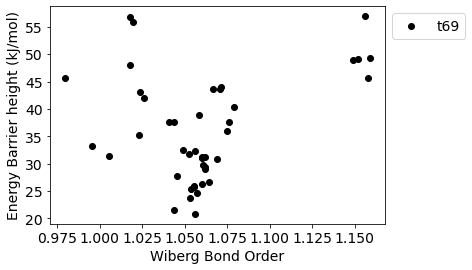

No handles with labels found to put in legend.


Fragmenter paper


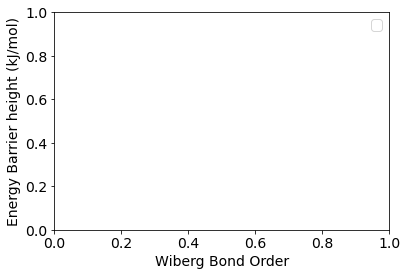

No handles with labels found to put in legend.


OpenFF DANCE 1 eMolecules t142 v1.0


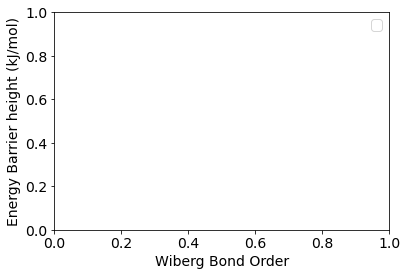

OpenFF Fragmenter Validation 1.0


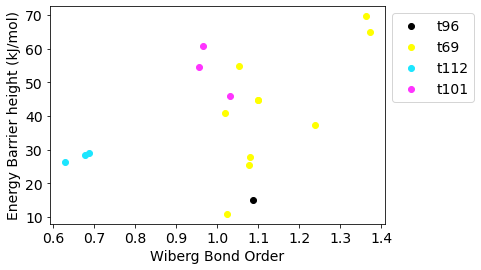

OpenFF Full TorsionDrive Benchmark 1


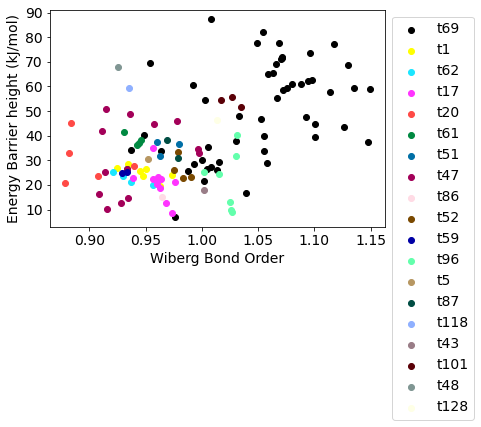

OpenFF Gen 2 Torsion Set 1 Roche


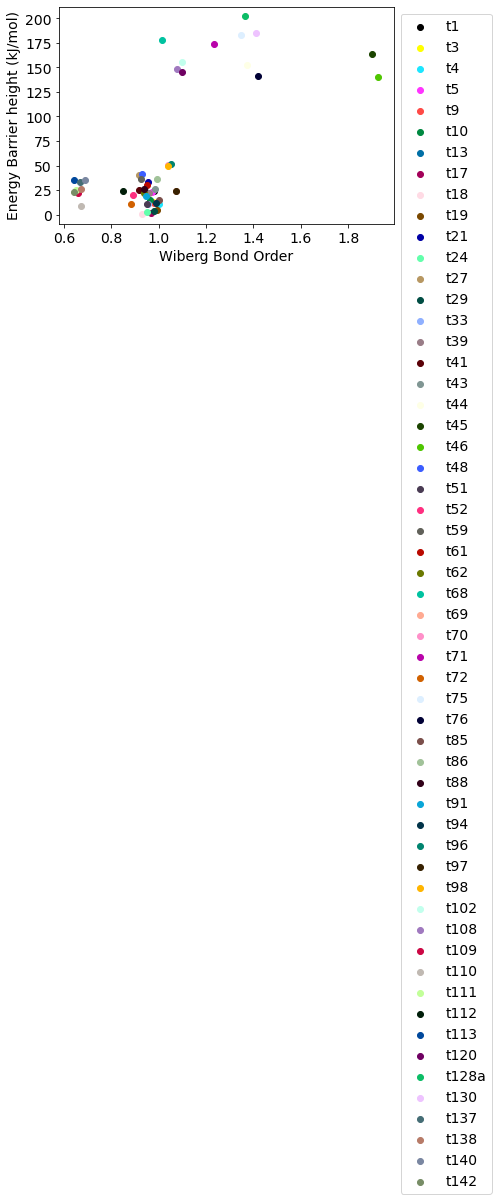

OpenFF Gen 2 Torsion Set 1 Roche 2


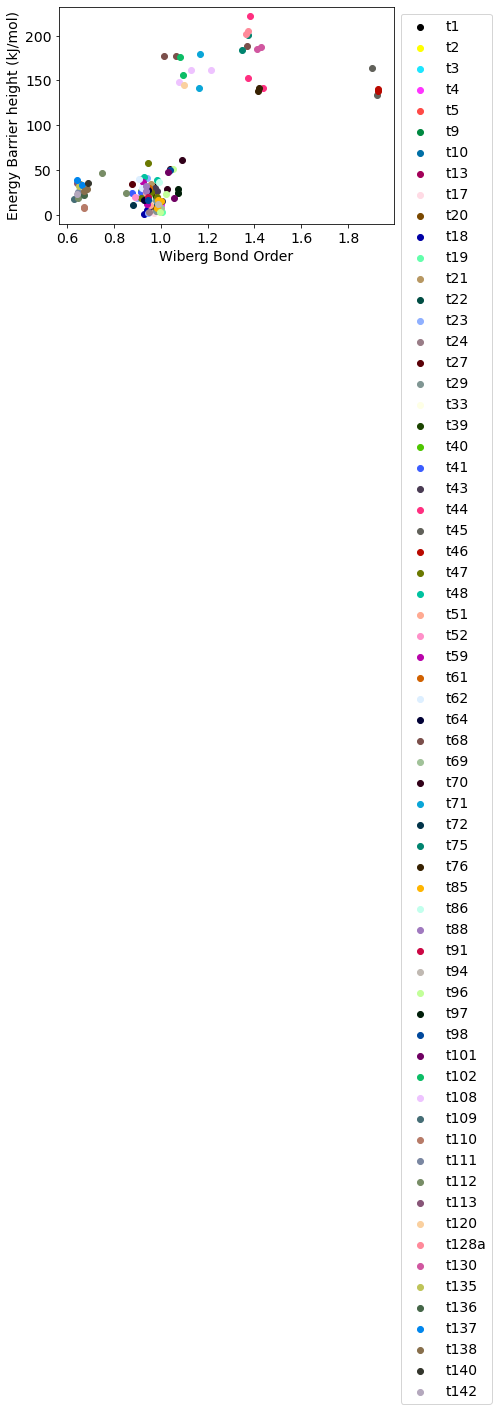

OpenFF Gen 2 Torsion Set 2 Coverage


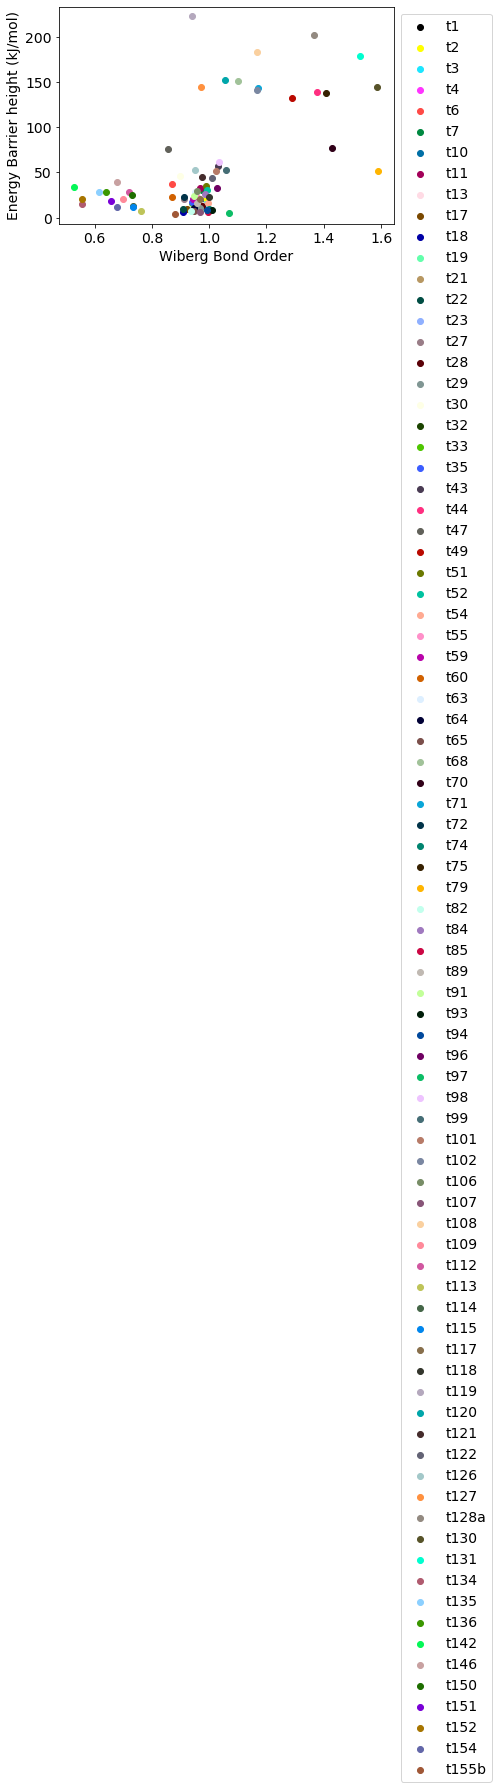

OpenFF Gen 2 Torsion Set 2 Coverage 2


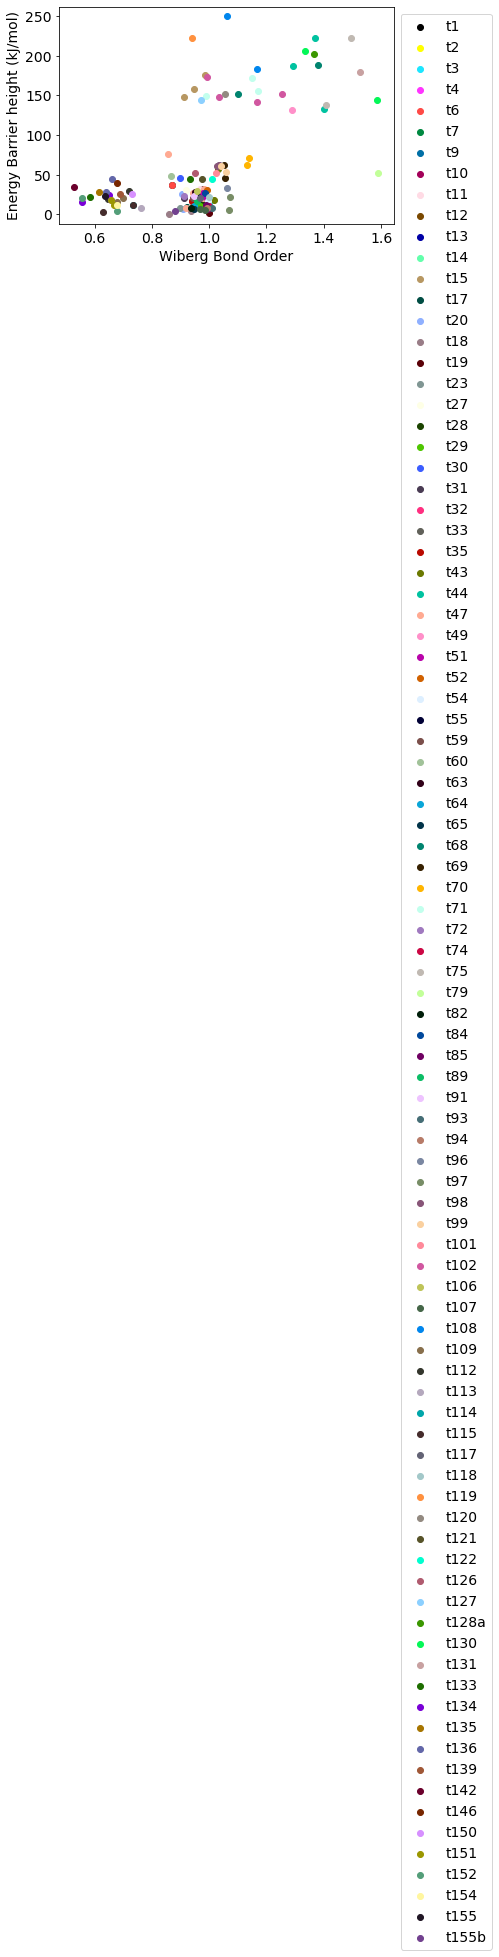

OpenFF Gen 2 Torsion Set 3 Pfizer Discrepancy


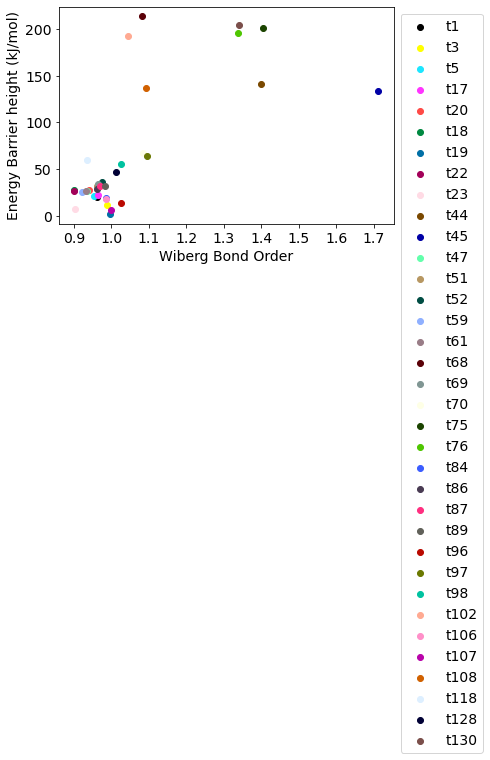

OpenFF Gen 2 Torsion Set 3 Pfizer Discrepancy 2


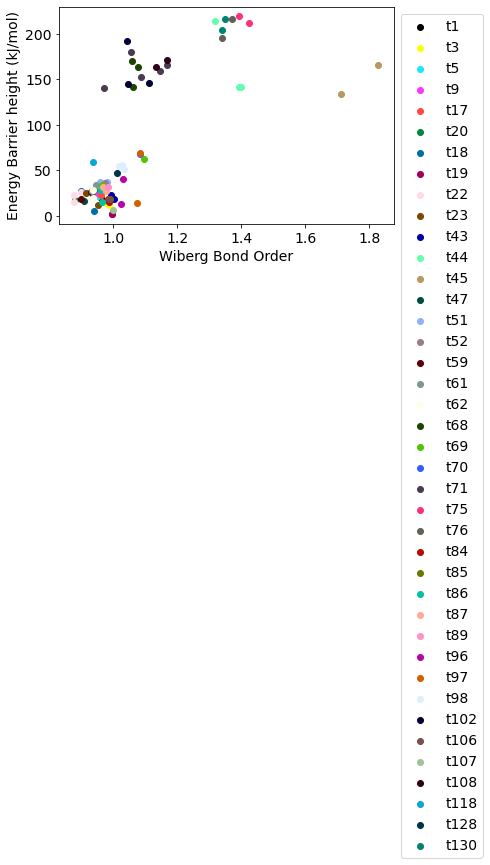

OpenFF Gen 2 Torsion Set 4 eMolecules Discrepancy


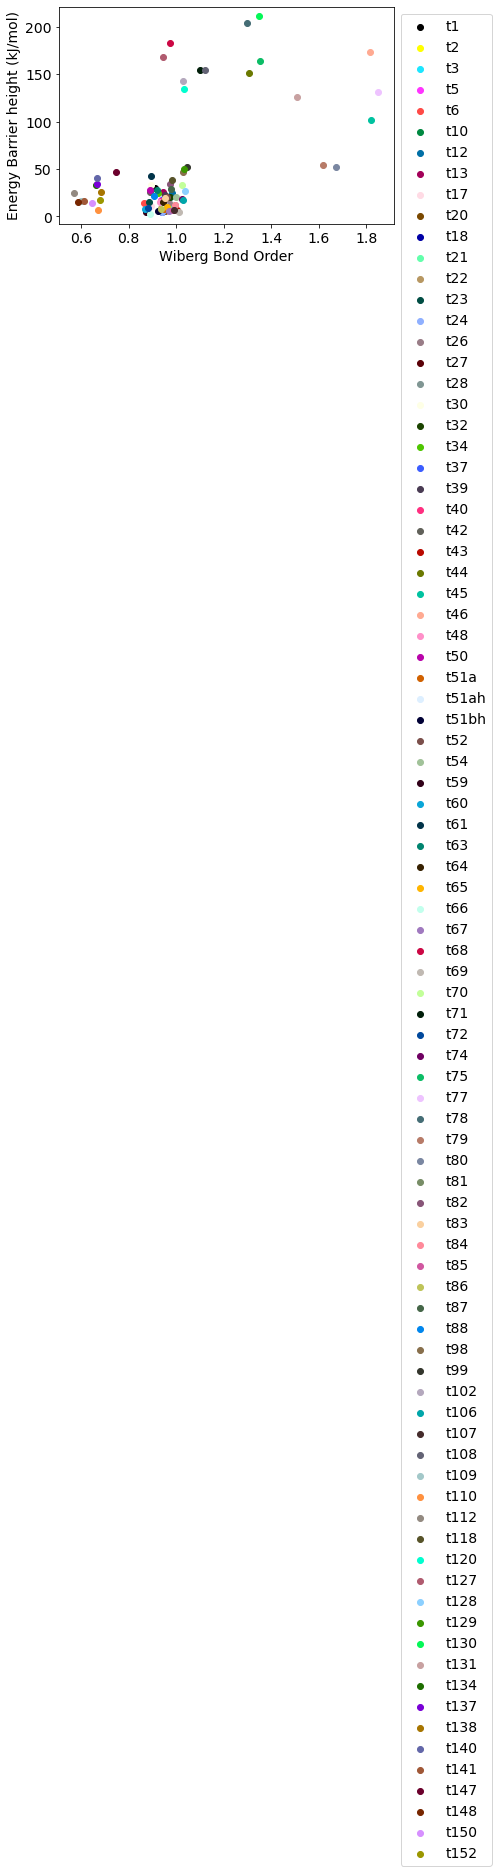

OpenFF Gen 2 Torsion Set 4 eMolecules Discrepancy 2
OpenFF Gen 2 Torsion Set 5 Bayer


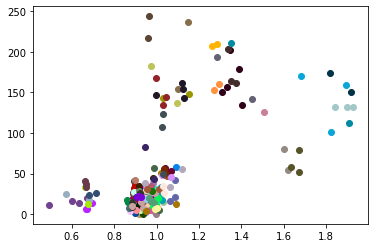

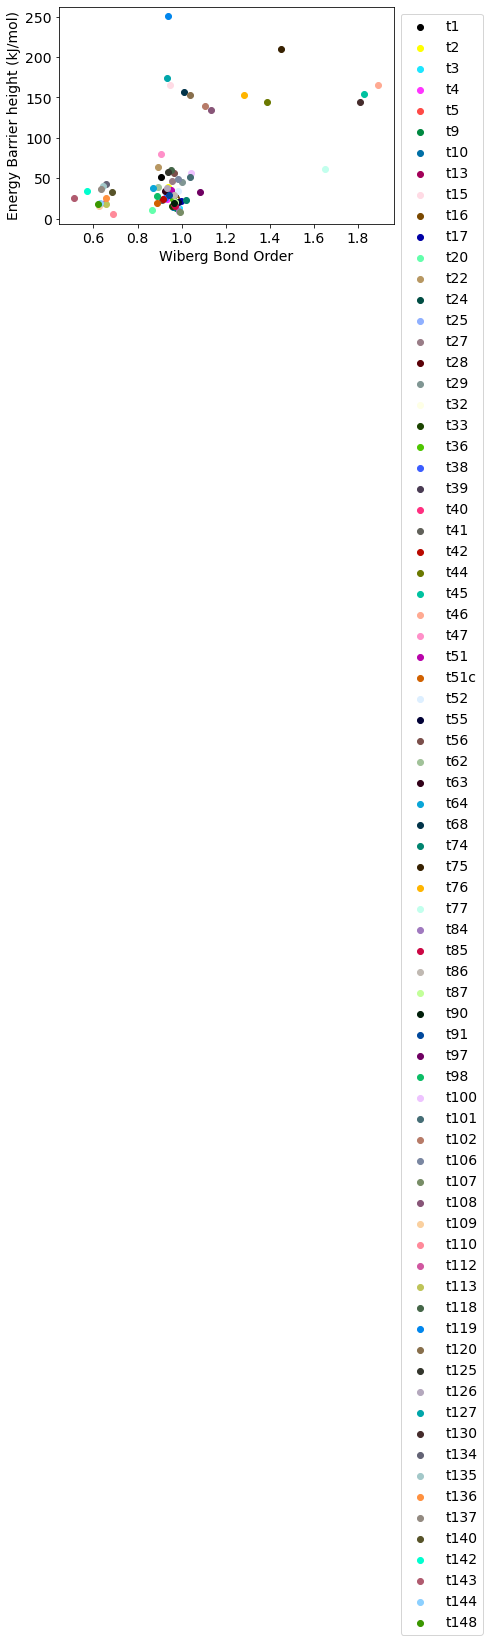

OpenFF Gen 2 Torsion Set 5 Bayer 2


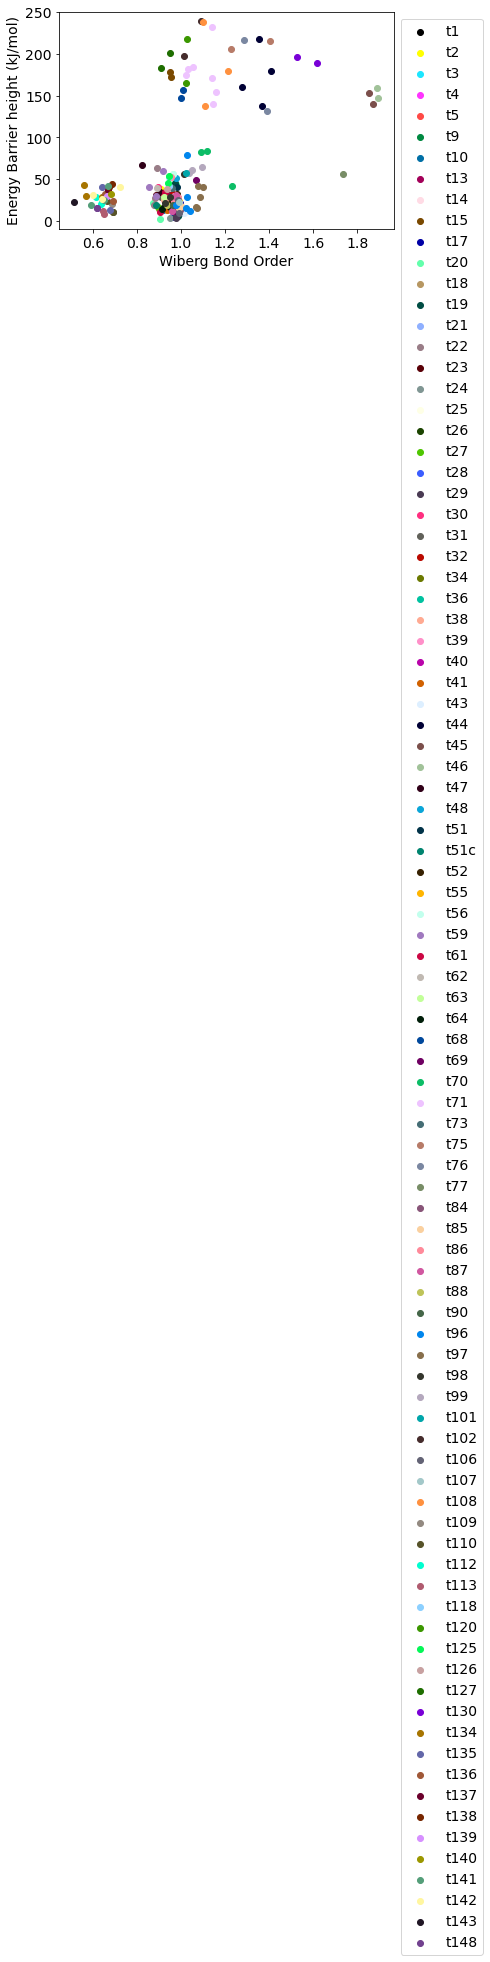

OpenFF Gen 2 Torsion Set 6 Supplemental


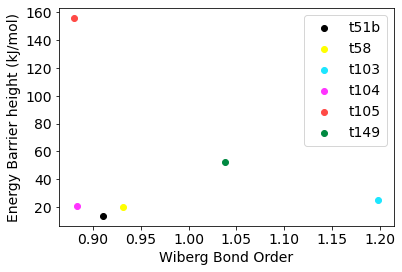

OpenFF Gen 2 Torsion Set 6 Supplemental 2


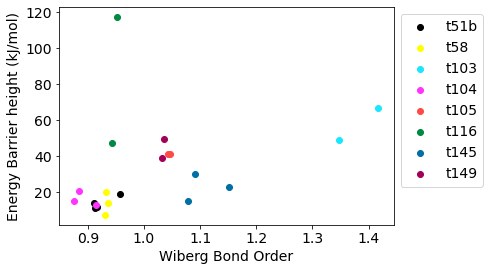

OpenFF Group1 Torsions


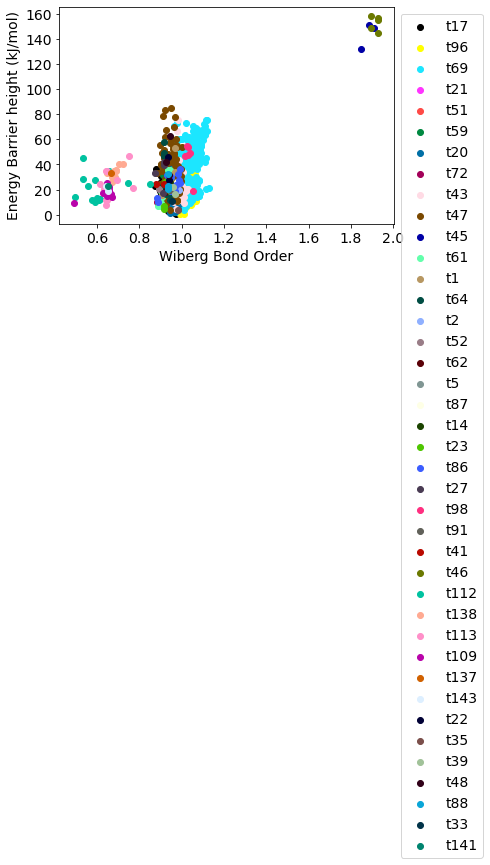

OpenFF Group1 Torsions 2


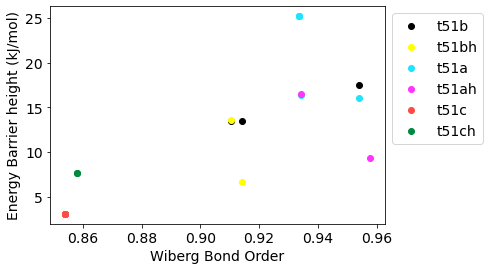

OpenFF Group1 Torsions 3


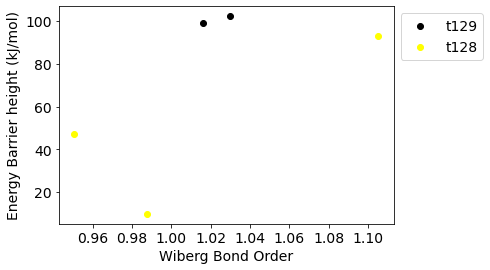

OpenFF Primary Benchmark 1 Torsion Set


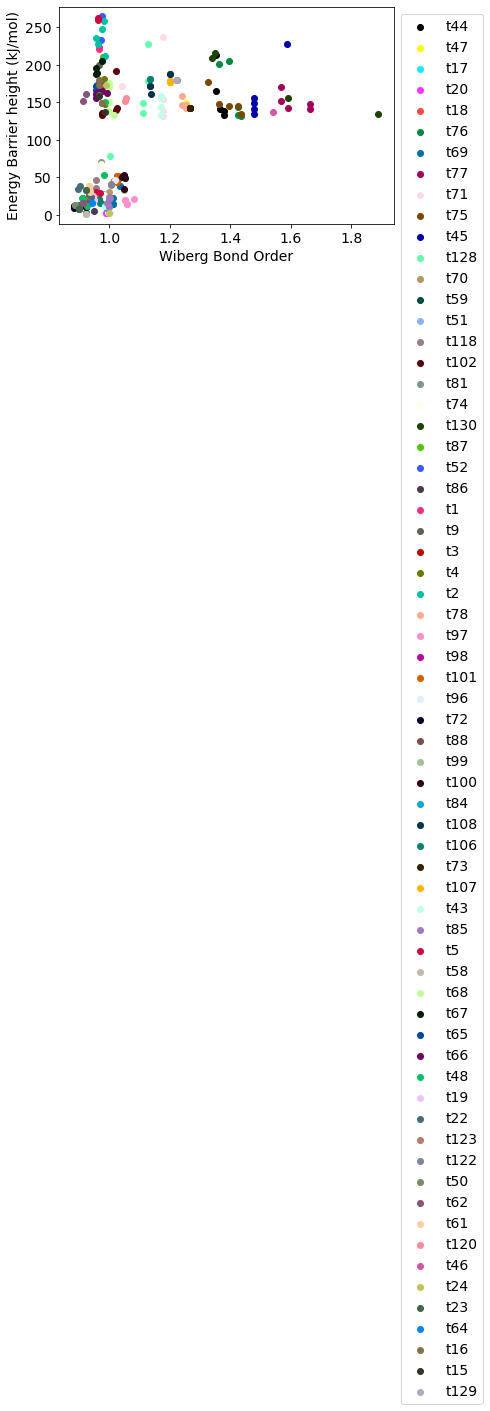

No handles with labels found to put in legend.


OpenFF Primary Benchmark 2 Torsion Set


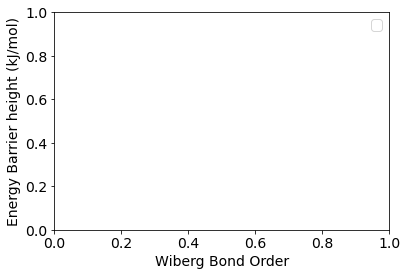

OpenFF Primary TorsionDrive Benchmark 1


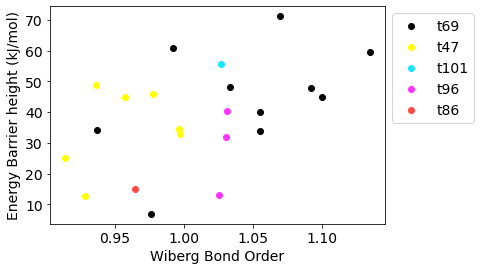

OpenFF Rowley Biaryl v1.0


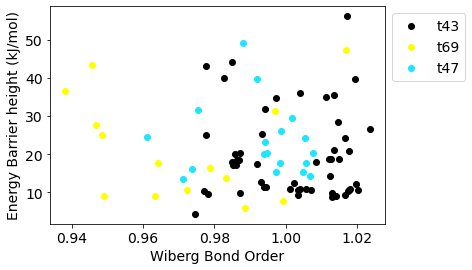

OpenFF Substituted Phenyl Set 1


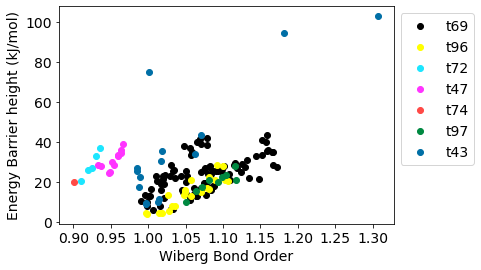

OpenFF-benchmark-ligand-fragments-v1.0


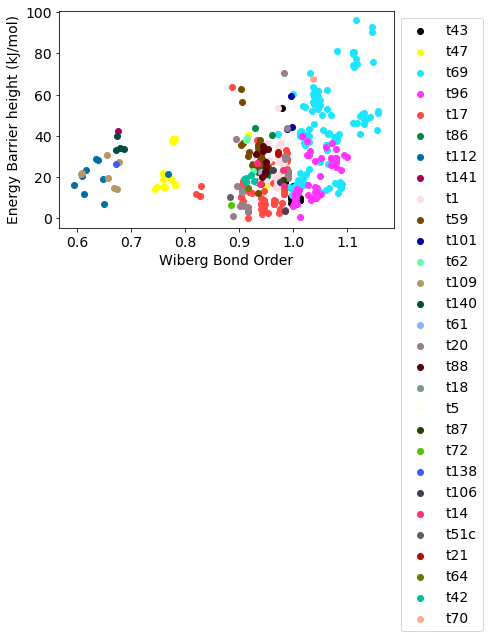

Pfizer Discrepancy Torsion Dataset 1


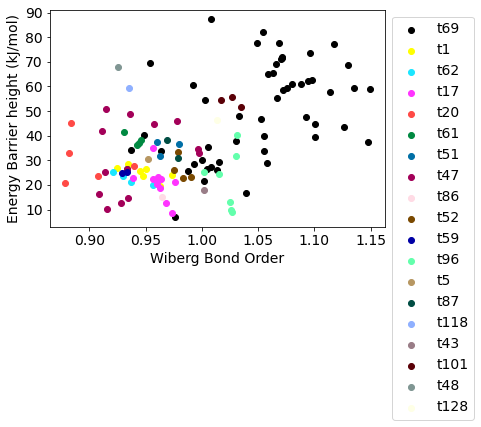

SMIRNOFF Coverage Torsion Set 1


No handles with labels found to put in legend.


SiliconTX Torsion Benchmark Set 1


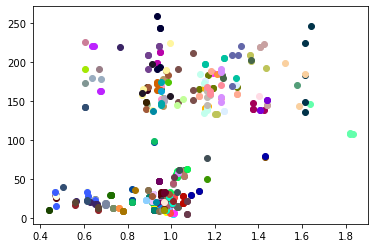

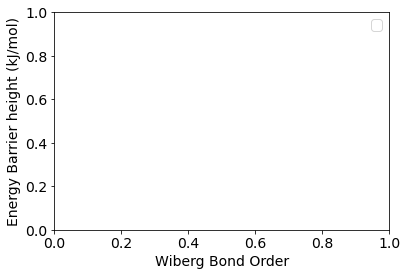

TorsionDrive Paper


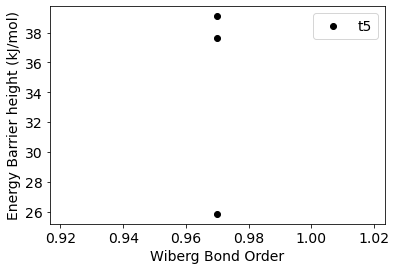

['OpenFF Gen 2 Torsion Set 4 eMolecules Discrepancy 2', 'SMIRNOFF Coverage Torsion Set 1']


In [19]:
with open('TD_datasets', 'r') as file:
    TD_datasets = file.read().splitlines()
error_td = []
count = 0
for td_name in TD_datasets:
    count += 1
    print(td_name)
    while True:
        try:
            genData(td_name, td_name)
#             genPlots(td_name+'.oeb', td_name+'.pdf')
            break
        except:
            error_td.append(td_name)
            break
print(error_td)

In [ ]:
#Let's also add the Rowley dataset and compare 
# genData("OpenFF Rowley Biaryl v1.0", "rowley")
# visualize_wbo_correlation_compare('phenyl.oeb', 'rowley.oeb', "rowley_and_phenyl.pdf")

In [ ]:
visualize_wbo_correlation_compare('phenyl.oeb', 'rowley.oeb', "rowley_and_phenyl.pdf")

In [88]:
def plot_interactive(fileList, t_id=None):
    """
    Takes in a list of oeb files and plots wbo vs torsion barrier, combining all the datasets and plotting by each tid in the combined dataset
    
    Note: ***Plot is interactive (or returns chemical structures) only for the last usage
    
    Parameters
    ----------
    fileList: list of strings
    each string is a oeb file name
    Eg. ['rowley.oeb'] or ['rowley.oeb', 'phenyl.oeb']
    
    t_id: str
    torsion id, eg., 't43'
    """
    import plotly.express as px
    from jupyter_dash import JupyterDash
    import dash_core_components as dcc
    import dash_html_components as html
    import pandas as pd
    import plotly.graph_objects as go
    from dash.dependencies import Input, Output
    from rdkit import Chem
    from rdkit.Chem.Draw import MolsToGridImage
    import base64
    from io import BytesIO

    molList = []
    for fileName in fileList:
        molList.extend(oeb2oemol(fileName))

    df = pd.DataFrame(columns = ['tid', 'tb', 'wbo', 'cmiles', 'TDindices']) 

    for m in molList:
        tid=m.GetData("IDMatch")
        df = df.append({'tid': tid, 
                        'tb': m.GetData("TB"),
                        'wbo' : m.GetData("WBO"),
                        'cmiles' : m.GetData("cmiles"),
                        'TDindices' : m.GetData("TDindices")}, 
                        ignore_index = True)
    if(t_id):
        print(t_id, "only")
        df = df[df.tid == t_id]

    colors = fragmenter.chemi._KELLYS_COLORS

    fig = go.Figure({'layout' : go.Layout(height=400,
            xaxis={'title': 'Wiberg Bond Order'},
            yaxis={'title': 'Torsion barrier in KJ/mol'},
            margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
            legend={'x': 1, 'y': 1},
            hovermode=False,
            dragmode='select')})

    count = 0
    for tid in df.tid.unique():
        x = df[df.tid == tid].wbo
        y = df.loc[x.index].tb
        fig.add_scatter(x=x,
                        y=y,
                        mode="markers", 
                        name=tid, 
                        marker_color=colors[count])

        slope, intercept, r_value, p_value, std_err =    stats.linregress(x, y)
        print("tid: ", tid, "r_value: ", r_value, 
              "slope: ", slope, "intercept: ", intercept)
        ci_r_value = arch.bootstrap.IIDBootstrap(
            np.asarray(x), 
            np.asarray(y)).conf_int(compute_r_ci, 1000)
        CI_95 = 1.96*std_err
        fig.add_traces(go.Scatter(
            x=np.unique(x), 
            y=np.poly1d([slope, intercept])(np.unique(x)), 
            showlegend=False, mode ='lines', marker_color=colors[count]))
        count += 1

    graph_component = dcc.Graph(id="graph_id", figure=fig)
    image_component = html.Img(id="structure-image")

    app = JupyterDash(__name__) 

    app.layout = html.Div([
        html.Div([graph_component]), 
        html.Div([image_component])])

    @app.callback(
        Output('structure-image', 'src'),
        [Input('graph_id', 'selectedData')])
    def display_selected_data(selectedData):
        max_structs = 12
        structs_per_row = 1
        empty_plot = "data:image/gif;base64,R0lGODlhAQABAAAAACwAAAAAAQABAAA="
        if selectedData:
            if len(selectedData['points']) == 0:
                return empty_plot
            print("# of points selected = ", len(selectedData['points']))
            xval = [x['x'] for x in selectedData['points']]
            yval = [x['y'] for x in selectedData['points']]
            match_df = df[df['wbo'].isin(xval)]
            smiles_list = list(match_df.cmiles)
            name_list = list(match_df.tid)
            name_list = []
            
            for i in range(len(selectedData['points'])):
                indices_tup = match_df.iloc[i].TDindices
                tid = match_df.iloc[i].tid
                tor_bar = match_df.iloc[i].tb
                wbo_tor = match_df.iloc[i].wbo
                cmiles_str = match_df.iloc[i].cmiles
                tmp = [str(tid), ':', 'TDindices [', str(indices_tup[0]+1),
                       str(indices_tup[1]+1), str(indices_tup[2]+1), 
                       str(indices_tup[3]+1), ']', 
                       'wbo:', str('%.2f'%(wbo_tor)), 
                       'TB:', str('%.2f'%(tor_bar)), 'KJ/mol]']
                name_list.append(' '.join(tmp))
            mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
            img = MolsToGridImage(mol_list[0:max_structs], 
                                  subImgSize=(400, 400), 
                                  molsPerRow=structs_per_row, 
                                  legends=name_list)
            buffered = BytesIO()
            img.save(buffered, format="PNG", legendFontSize=40)
            encoded_image = base64.b64encode(buffered.getvalue())
            src_str = 'data:image/png;base64,{}'.format(encoded_image.decode())
        else:
            return empty_plot
        return src_str

    if __name__ == '__main__':   
        app.run_server(mode='inline', port=8060, debug=True)

    return fig


In [73]:
fig1 = plot_interactive(['rowley.oeb', 'phenyl.oeb'], t_id='t43')

t43 only
tid:  t43 r_value:  0.6771702920019153 slope:  275.65412975007723 intercept:  -255.6465785712414


# of points selected =  3


In [79]:
TD_working_oeb = [x+'.oeb' for x in TD_datasets]

In [80]:
all_t43 = plot_interactive(TD_working_oeb, t_id='t43')

t43 only
tid:  t43 r_value:  0.82272786065585 slope:  516.1768094538851 intercept:  -493.1300638906191


# of points selected =  4
# of points selected =  8


In [81]:
all_t47 = plot_interactive(TD_working_oeb, t_id='t47')

t47 only
tid:  t47 r_value:  0.47007273888214995 slope:  176.99239890029543 intercept:  -132.97817741324786


# of points selected =  5


In [82]:
all_t69 = plot_interactive(TD_working_oeb, t_id='t69')

t69 only
tid:  t69 r_value:  0.35907944435962336 slope:  125.62897873389376 intercept:  -93.9561666284743


In [83]:
all_t72 = plot_interactive(TD_working_oeb, t_id='t72')

t72 only
tid:  t72 r_value:  0.8263666065601866 slope:  400.3603316129027 intercept:  -343.26797691627957


In [84]:
all_t74 = plot_interactive(TD_working_oeb, t_id='t74')

t74 only
tid:  t74 r_value:  0.8986448767737627 slope:  587.3035983429953 intercept:  -540.0989489726342


In [85]:
all_t96 = plot_interactive(TD_working_oeb, t_id='t96')

t96 only
tid:  t96 r_value:  0.29066151843926763 slope:  126.9179004037672 intercept:  -110.9046664216262


In [89]:
all_t97 = plot_interactive(TD_working_oeb, t_id='t97')

t97 only
tid:  t97 r_value:  0.16836260981545084 slope:  129.25082559817088 intercept:  -115.28389791295297


# of points selected =  2
